In [126]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import copy
from copy import deepcopy

We will define a population of 10 units with binary activities. One spike is an activity value of 1 for 1 millisecond.<br>
We will simulate 15 seconds of time with a time resolution of 1 millisecond.<br>
Each unit will spike at a rate of 25 Hz for a duration of 1 second, with each unit active in a nonoverlapping time window.

In [127]:
input_dim = 10
input_rate = 25.  # Hz
input_dur = 1.  # sec
dt = 0.001  # sec
t_lim = 15.  # sec

In [128]:
input_locs = np.arange(0., input_dim, 1.)
t = np.arange(0., t_lim, dt)
pre_activity = np.zeros((input_dim, len(t)))
for i in range(input_dim):
    dur = 0.
    ISI = 1. / input_rate
    while dur < input_dur:
        index = np.where(t >= input_locs[i] + dur)[0][0]
        pre_activity[i, index] = 1.
        dur += ISI

<IPython.core.display.Javascript object>


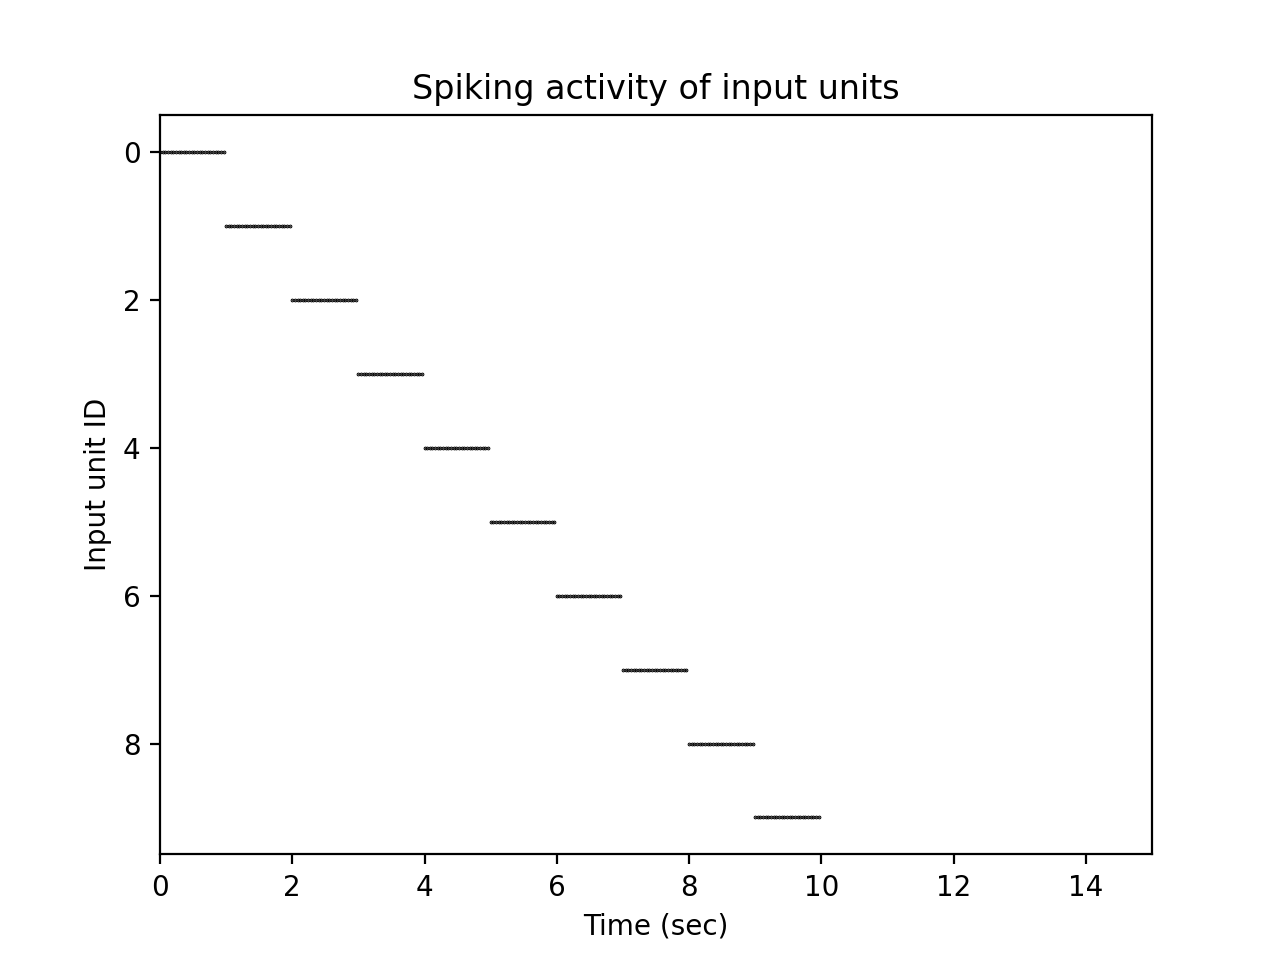

Text(0.5, 1.0, 'Spiking activity of input units')

In [129]:
plt.figure()
indexes = np.where(pre_activity > 0.)
plt.scatter(t[indexes[1]], indexes[0], marker='.', s=0.5, c='k')
plt.xlim(0., t_lim)
plt.ylim(input_dim - 0.5, -0.5)
plt.ylabel('Input unit ID')
plt.xlabel('Time (sec)')
plt.title('Spiking activity of input units')

Let's first consider a single post-synaptic unit that receives all the inputs.<br>
We will compute the voltage of the postsynaptic cell over time.<br>
Each time a pre-synaptic unit spikes, the voltage of the postsynaptic cell will increment by a certain amount that depends on the weight of the input.<br>
Then, the voltage of the post-synaptic cell will decay back to zero with some time constant.<br><br>
Initially, we will set all the input weights to an equal value of 0.5

In [167]:
w0 = np.ones(pre_activity.shape[0]) * 0.5

<IPython.core.display.Javascript object>


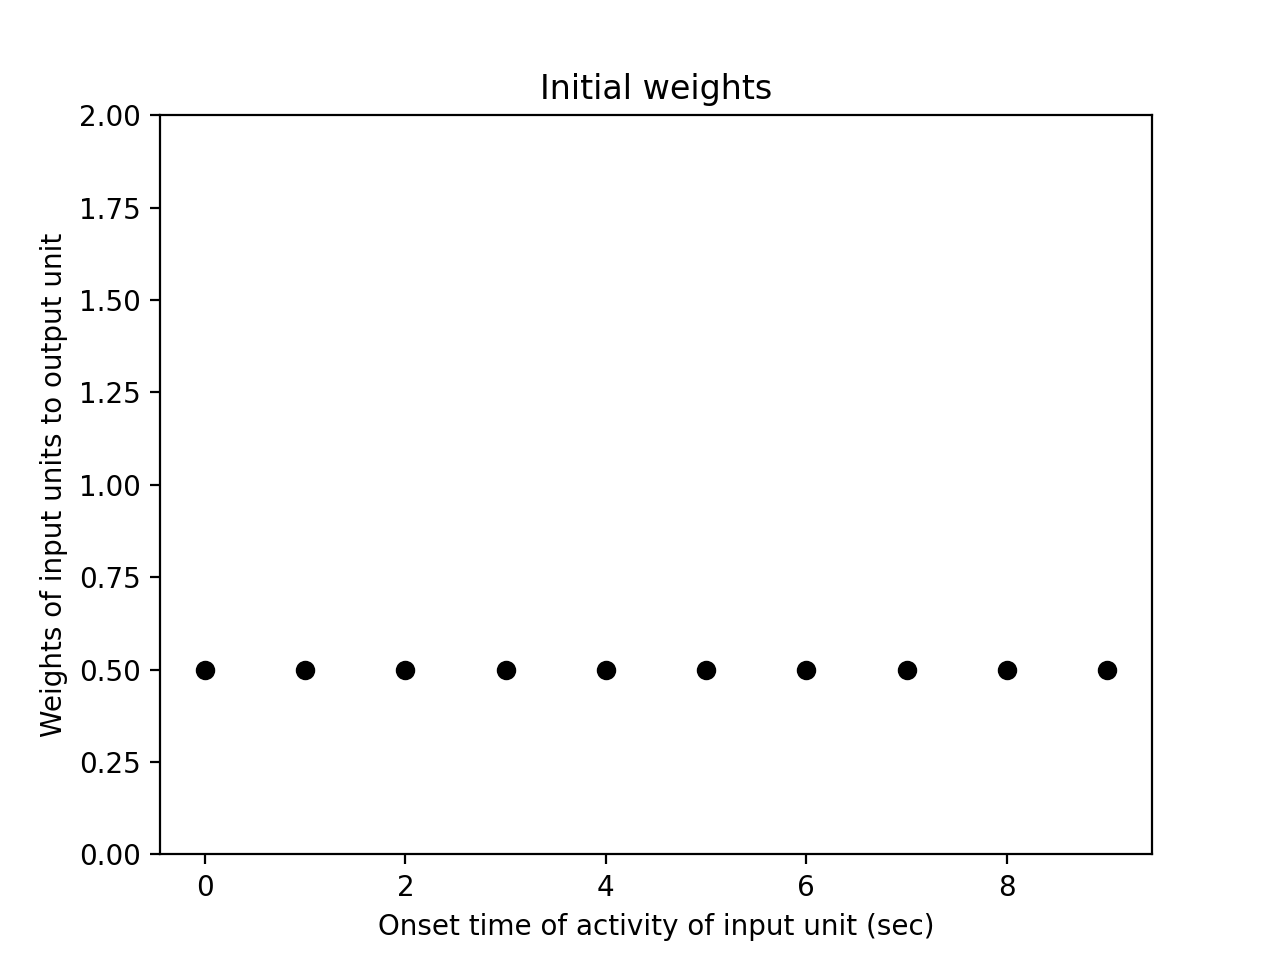

In [168]:
plt.figure()
plt.scatter(input_locs, w0, c='k')
plt.ylabel('Weights of input units to output unit')
plt.xlabel('Onset time of activity of input unit (sec)')
plt.title('Initial weights')
plt.ylim(0., 2.)
plt.show()

The rate of change of the voltage of the postsynaptic cell will be described by the following differential equation.<br>
In each time step, dt, voltage changes in response to synaptic input.<br>
In the absence of input, voltage decays exponentially.

In [169]:
def get_exp_decay_dsignal_dt(i, signal, decay_tau, act_rate):
    """
    :param i: float; input value between 0 and 1
    :param signal: float; signal value
    :param decay_tau: float; decay time constant in sec
    :param act_rate: float; rate to increment signal in reponse to nonzero input; Hz
    """
    return (-signal + act_rate * i) / decay_tau

In [170]:
v_decay_tau = 0.05  # s
v_act_rate = 20.
v0 = 0

v = []
vi = v0
weights = np.copy(w0)
for i in range(len(t)):
    # weighted sum of inputs in this time step
    summed_input = weights.dot(pre_activity[:,i])
    dv_dt = get_exp_decay_dsignal_dt(summed_input, vi, v_decay_tau, v_act_rate)
    vi += dv_dt * dt
    v.append(vi)

<IPython.core.display.Javascript object>


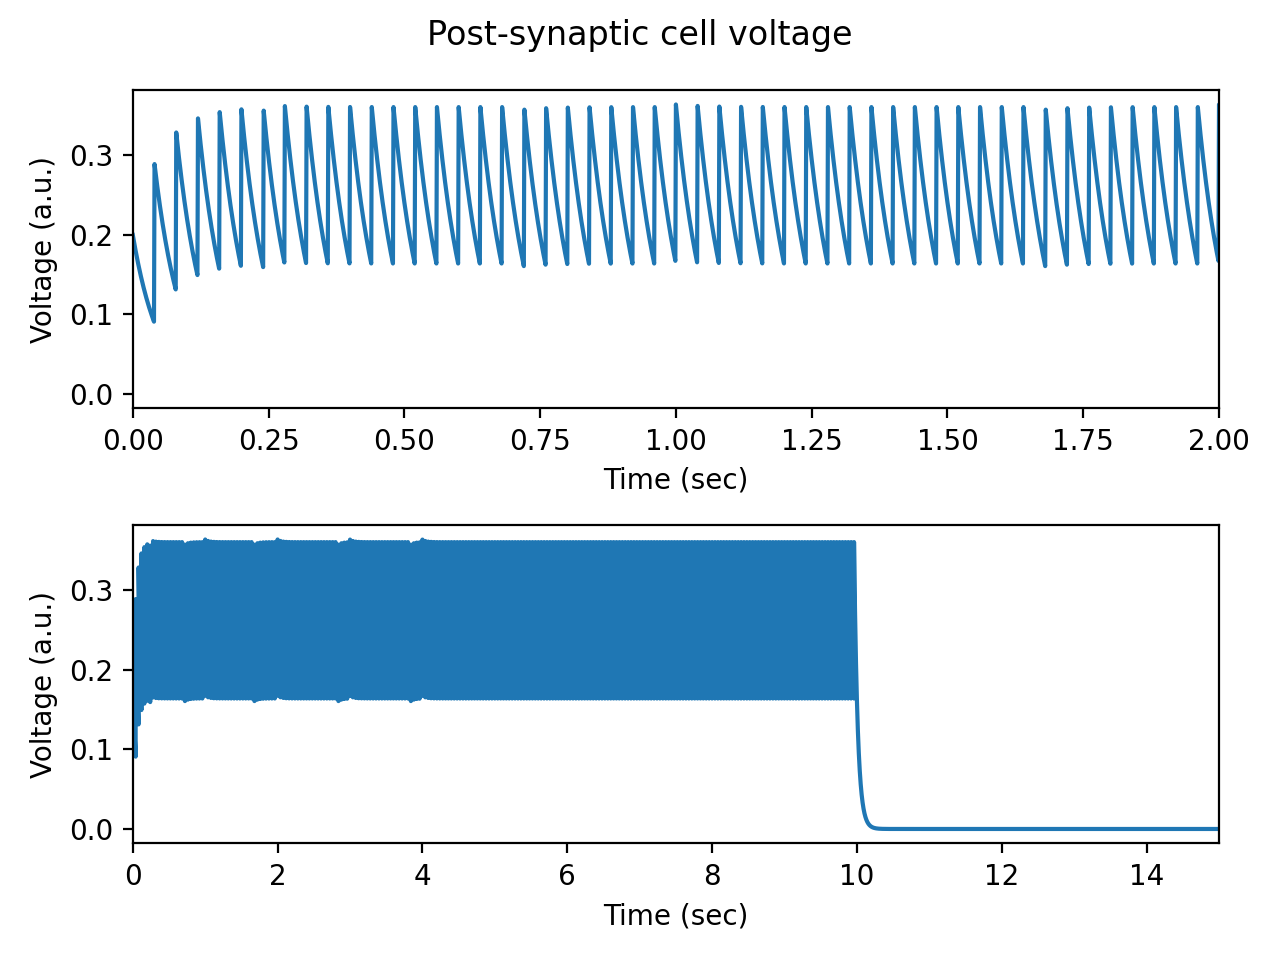

In [171]:
fig, axes = plt.subplots(2)
axes[0].plot(t, v)
axes[1].plot(t, v)
axes[0].set_xlim(0., 2.)
axes[0].set_ylabel('Voltage (a.u.)')
axes[1].set_ylabel('Voltage (a.u.)')
fig.suptitle('Post-synaptic cell voltage')
axes[0].set_xlabel('Time (sec)')
axes[1].set_xlabel('Time (sec)')
axes[1].set_xlim(0., t_lim)
fig.tight_layout()
fig.show()

Now we want to use this intracellular voltage signal to decide when to generate an output spike.<br>
A leaky integrate-and-fire neuron compares this voltage to a threshold, and then sets the voltage equal to a large value for the duration of spike.<br>
Spikes are usually followed by an inactive refractory period during which the voltage is set to a low value.

In [172]:
v = []
vi = v0
post_activity = []
last_spike_time = None
spike_dur = 0.001
spike_refractory = 0.005
v_spike_th = 0.35

for i in range(len(t)):
    if last_spike_time is None or t[i] - last_spike_time > spike_dur + spike_refractory:
        if vi >= v_spike_th:
            vi = 1.
            last_spike_time = t[i]
            post_activity.append(1.)
        else:
            # weighted sum of inputs in this time step
            summed_input = weights.dot(pre_activity[:,i])
            dv_dt = get_exp_decay_dsignal_dt(summed_input, vi, v_decay_tau, v_act_rate)
            vi += dv_dt * dt
            post_activity.append(0.)
    elif t[i] - last_spike_time < spike_dur:
        vi = 1.
        post_activity.append(1.)
    elif t[i] - last_spike_time < spike_dur + spike_refractory:
        vi = 0.
        post_activity.append(0.)
    v.append(vi)

<IPython.core.display.Javascript object>


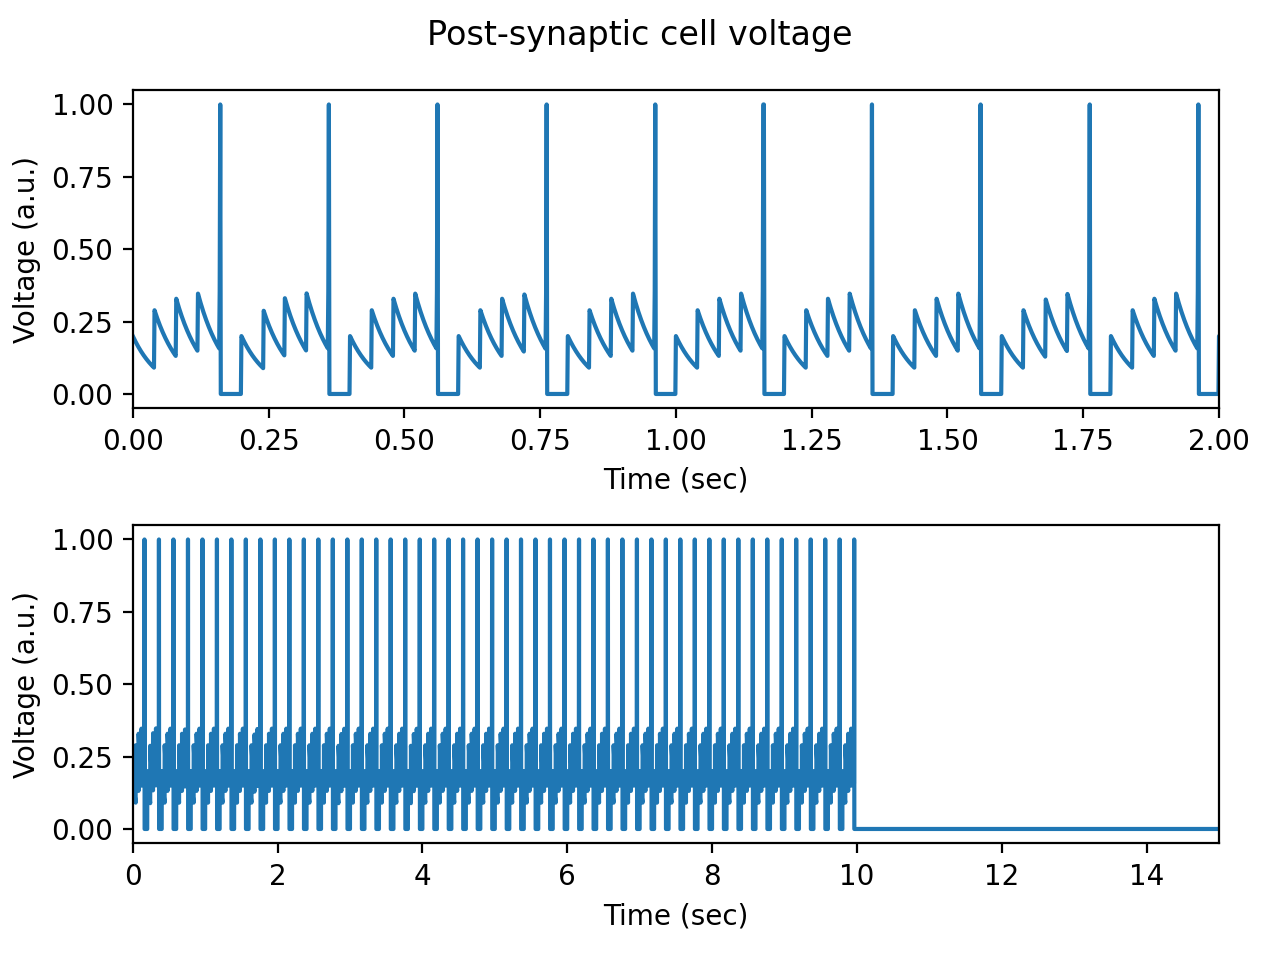

In [173]:
fig, axes = plt.subplots(2)
axes[0].plot(t, v)
axes[1].plot(t, v)
axes[0].set_xlim(0., 2.)
axes[0].set_ylabel('Voltage (a.u.)')
axes[1].set_ylabel('Voltage (a.u.)')
fig.suptitle('Post-synaptic cell voltage')
axes[0].set_xlabel('Time (sec)')
axes[1].set_xlabel('Time (sec)')
axes[1].set_xlim(0., t_lim)
fig.tight_layout()
fig.show()

Now we want to implement a learning rule to update the weights of each input.<br>
We want changes in synaptic weight to be related to the firing rate of each presynaptic unit. But all we have is 1 ms long binary signals, not a metric of activity rate.<br>
We need each synapse to keep a record of the history of activation that will increment each time a spike arrives, and decay over time.<br>
This is will determine whether an input is eligible for a weight update, and is called an "eligibility trace".<br>

This eligibility trace is saturable up to maximum value of 1.

In [174]:
def get_sat_exp_decay_dsignal_dt(i, signal, decay_tau, sat, act_rate):
    """
    :param i: float; input value between 0 and 1
    :param signal: float; signal value between 0 and sat
    :param decay_tau: float; decay time constant in sec
    :param sat: float; saturating value of signal
    :param act_rate: float; rate to increment signal in reponse to nonzero input; Hz
    """
    return (-signal + act_rate * (sat - signal) * i) / decay_tau

In [175]:
ET_0 = np.zeros(pre_activity.shape[0])
ET = np.empty_like(pre_activity)

ET_decay_tau = 1.  # sec
ET_sat = 1.
ET_act_rate = 100. 

ET_i = np.array(ET_0)
for i in range(len(t)):
    dET_dt = get_sat_exp_decay_dsignal_dt(pre_activity[:,i], ET_i, ET_decay_tau, ET_sat, ET_act_rate)
    ET_i += dET_dt * dt
    ET_i = np.minimum(ET_sat, np.maximum(0., ET_i))
    ET[:,i] = ET_i

Here is the postsynaptic eligibility trace for one presynaptic input from unit 5:

<IPython.core.display.Javascript object>


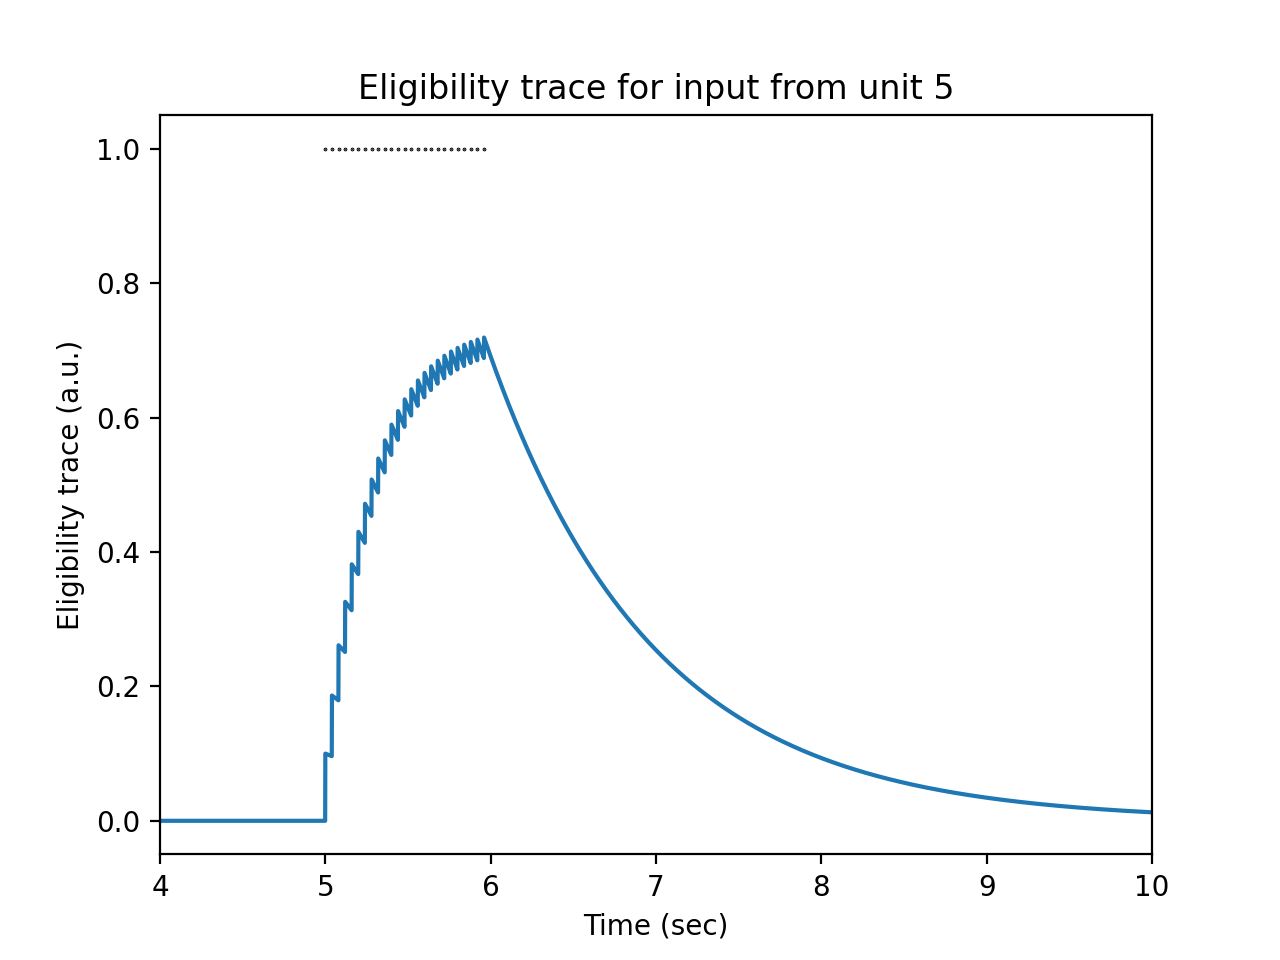

In [176]:
plt.figure()
plt.plot(t, ET[5])
indexes = np.where(pre_activity[5] > 0.)
plt.scatter(t[indexes], np.ones_like(indexes), c='k', marker='.', s=0.5)
plt.xlabel('Time (sec)')
plt.xlim(4., 10.)
plt.ylabel('Eligibility trace (a.u.)')
plt.title('Eligibility trace for input from unit 5')
plt.show()

Here are eligibility traces for all 10 presynaptic inputs:

<IPython.core.display.Javascript object>


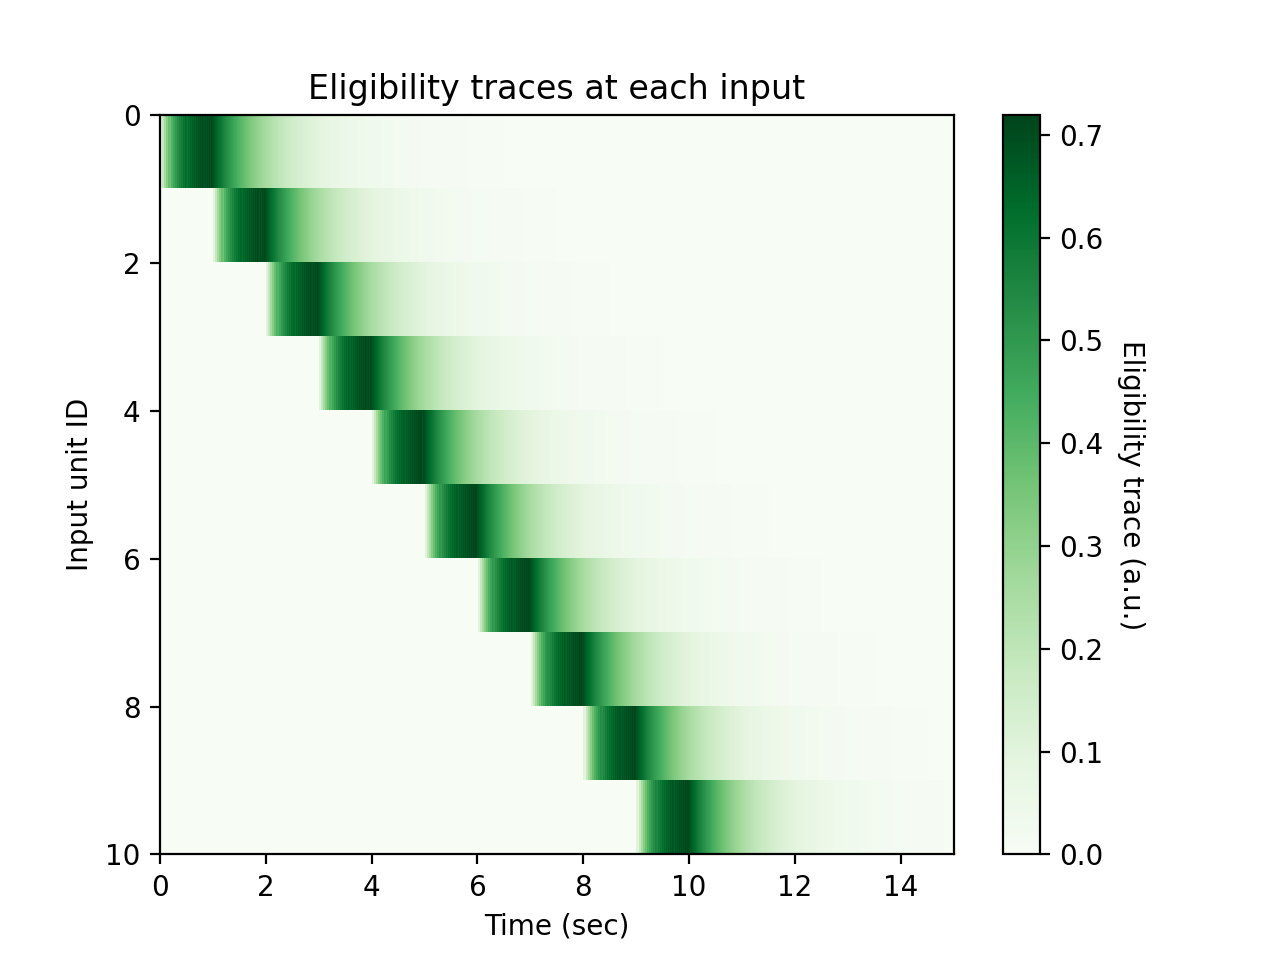

In [177]:
plt.figure()
im = plt.imshow(ET, aspect='auto', cmap='Greens', extent=(0., t_lim, input_dim, 0), interpolation='none')
cbar = plt.colorbar(im)
cbar.set_label('Eligibility trace (a.u.)', rotation=270., labelpad=15)
plt.xlabel('Time (sec)')
plt.ylabel('Input unit ID')
plt.title('Eligibility traces at each input')
plt.show()

Now we are going to define a second compartment of the postsynaptic neuron.<br>
This dendrite compartment is going to have a voltage that is independent from the soma/output compartment voltage that we have already defined above.<br>
Just like the soma, the dendrite can also generate a spike when its voltage exceeds a threshold.<br>
But dendritic calcium spikes will last longer (300 ms), and will be followed by a longer refractory period (500 ms).<br>

For illustrative purposes, we will directly inject a teaching signal input to the dendrite of a cell to evoke a calcium spike.<br>

In [180]:
teaching_input = np.zeros_like(t)
teaching_signal_loc = 5.  # sec
teaching_signal_dur = 0.3 # sec
indexes = np.where((t >= teaching_signal_loc) & (t < teaching_signal_loc + teaching_signal_dur))
teaching_input[indexes] = 1.

dend_v0 = 0.
dend_v = []
dend_v_decay_tau = 0.02  # s
dend_v_act_rate = 0.5

dend_vi = dend_v0

dend_ca_spike = []
last_ca_spike_time = None
ca_spike_dur = 0.3
ca_spike_refractory = 0.5
dend_v_ca_spike_th = 0.25

for i in range(len(t)):
    if last_ca_spike_time is None or t[i] - last_ca_spike_time > ca_spike_dur + ca_spike_refractory:
        if dend_vi >= dend_v_ca_spike_th:
            last_ca_spike_time = t[i]
            dend_vi = 1.
            dend_ca_spike.append(1.)
        else:
            d_dend_v_dt = get_exp_decay_dsignal_dt(teaching_input[i], dend_vi, dend_v_decay_tau, dend_v_act_rate)
            dend_vi += d_dend_v_dt * dt    
            dend_ca_spike.append(0.)
    elif t[i] - last_ca_spike_time < ca_spike_dur:
        dend_vi = 1.
        dend_ca_spike.append(1.)
    elif t[i] - last_ca_spike_time < ca_spike_dur + ca_spike_refractory:
        dend_vi = 0.
        dend_ca_spike.append(0.)
    dend_v.append(dend_vi)

<IPython.core.display.Javascript object>


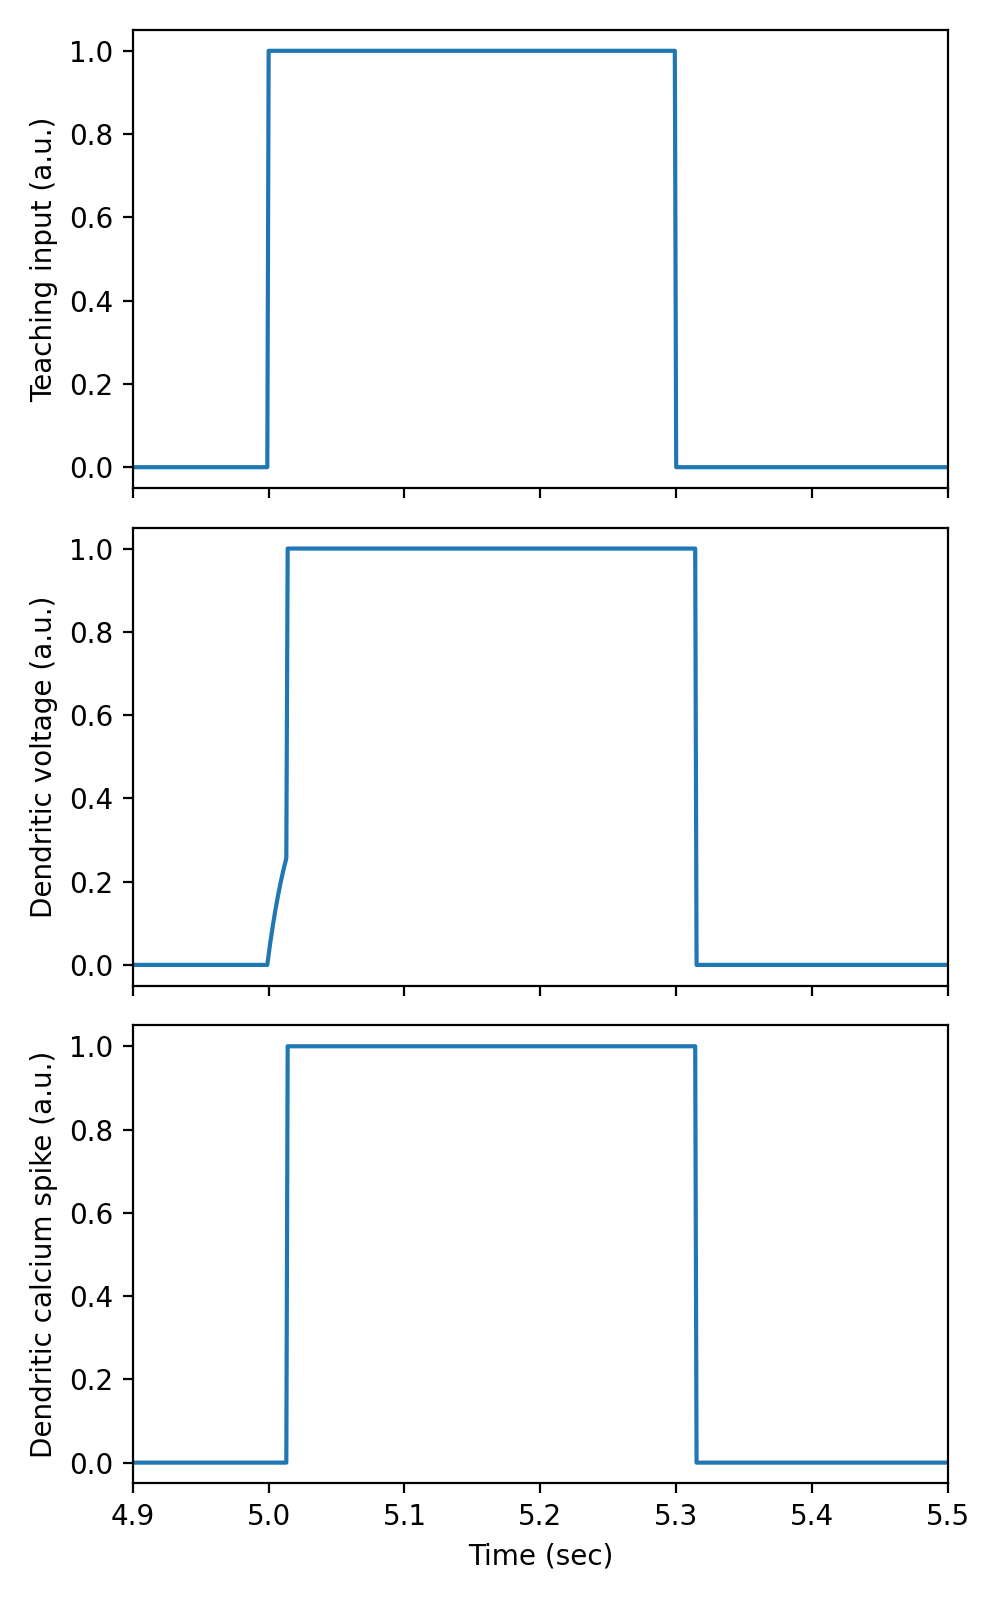

In [181]:
fig, axes = plt.subplots(3, figsize=(5., 8.), sharex=True)
axes[0].plot(t, teaching_input)
axes[0].set_ylabel('Teaching input (a.u.)')
axes[1].plot(t, dend_v)
axes[1].set_ylabel('Dendritic voltage (a.u.)')
axes[2].plot(t, dend_ca_spike)
axes[2].set_ylabel('Dendritic calcium spike (a.u.)')
axes[2].set_xlabel('Time (sec)')
axes[2].set_xlim(4.9, 5.5)
fig.tight_layout()
fig.show()

When a dendritic calcium spike occurs in the dendritic compartment, this binary signal will be communicated to the soma/output compartment in order to influence changes in synaptic weights at the feedforward inputs.<br>
Similar to the synaptic eligibility traces that keep track of the history of each synaptic input, we will also keep a history of recent dendritic calcium spikes.<br>
This history trace is called an "Instructive signal" and will be consulted in changing the weights of the feedforward synaptic inputs.<br>
This trace saturates at a maximum value of 1.

In [182]:
IS_0 = 0.
IS = []
IS_decay_tau = 0.75
IS_sat = 1.
IS_act_rate = 25.

IS_i = IS_0

for i in range(len(t)):
    d_IS_dt = get_sat_exp_decay_dsignal_dt(dend_ca_spike[i], IS_i, IS_decay_tau, IS_sat, IS_act_rate)
    IS_i += d_IS_dt * dt
    IS_i = min(IS_sat, max(0., IS_i))
    IS.append(IS_i)

<IPython.core.display.Javascript object>


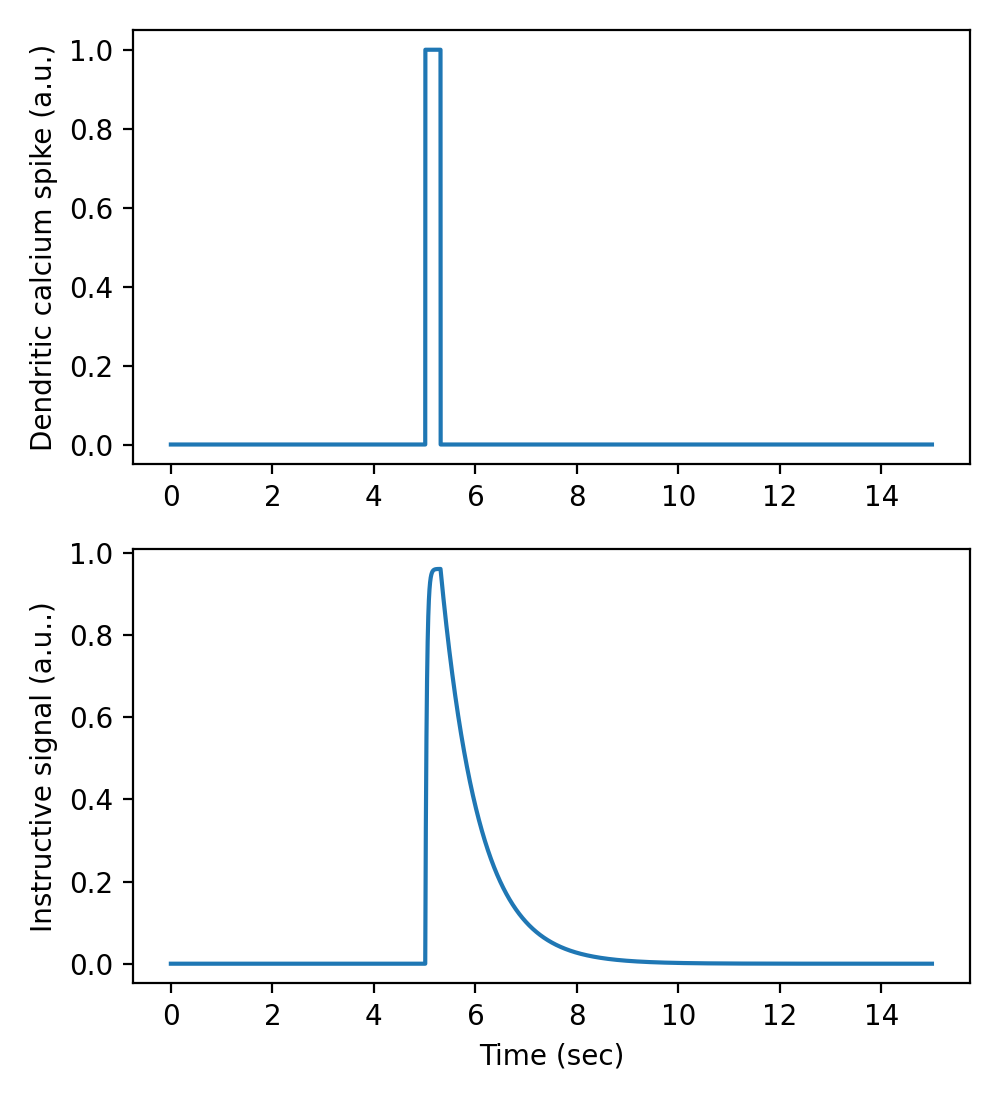

In [183]:
fig, axes = plt.subplots(2, figsize=(5., 5.5))
axes[0].plot(t, dend_ca_spike)
axes[0].set_ylabel('Dendritic calcium spike (a.u.)')
axes[1].plot(t, IS)
axes[1].set_ylabel('Instructive signal (a.u..)')
axes[1].set_xlabel('Time (sec)')
fig.tight_layout()
fig.show()

Whenever both the Instructive signal, IS, and the Eligibility trace at an individual input are nonzero, synaptic weight changes will occur.<br>
We will now compute the product of these two signals at each input:

<IPython.core.display.Javascript object>


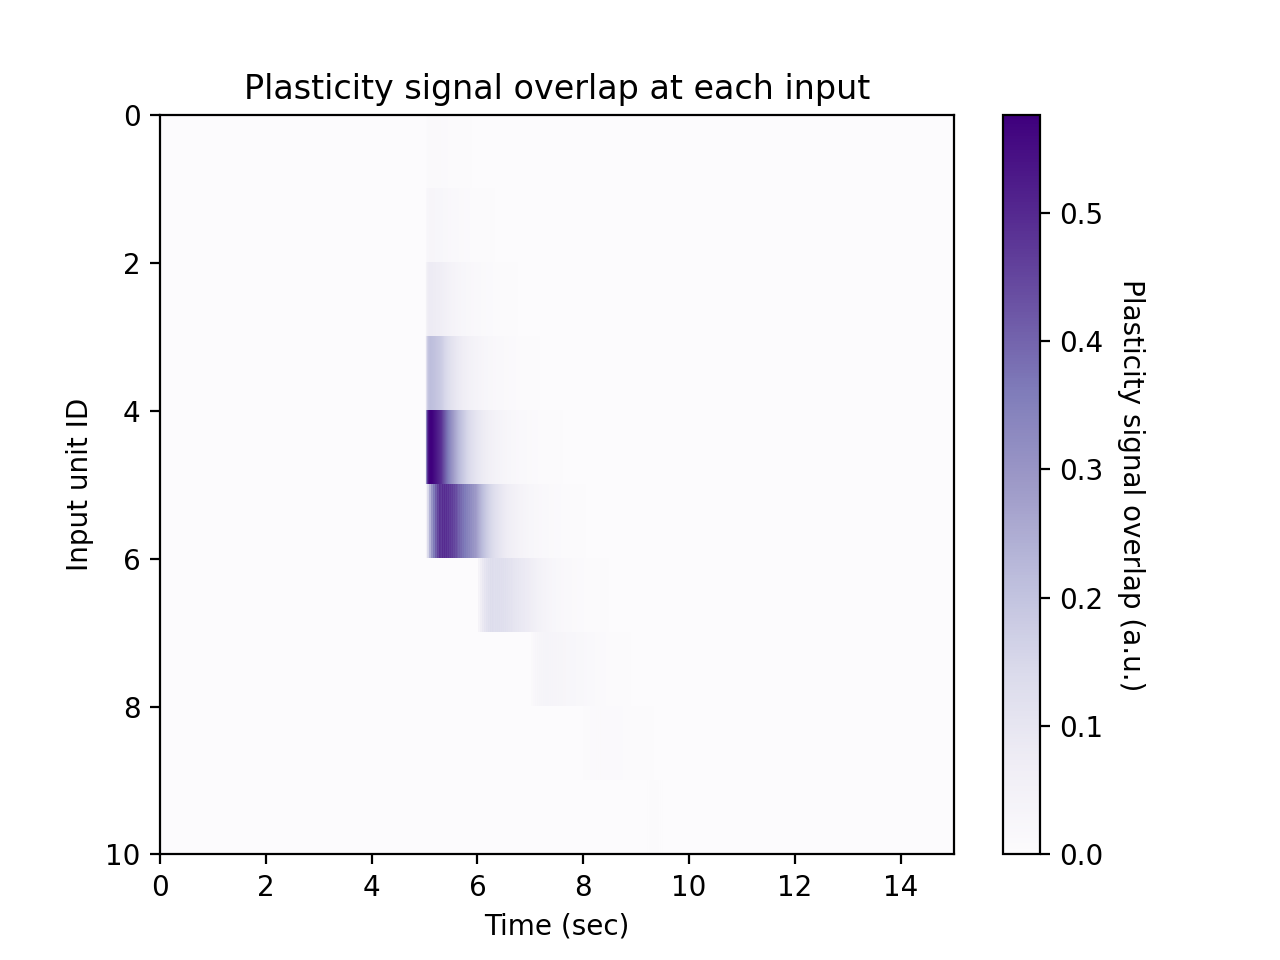

In [184]:
ET_IS = ET * IS

plt.figure()
im = plt.imshow(ET_IS, aspect='auto', extent=(0., t_lim, input_dim, 0), cmap='Purples', interpolation='none')
cbar = plt.colorbar(im)
cbar.set_label('Plasticity signal overlap (a.u.)', rotation=270., labelpad=15)
plt.xlabel('Time (sec)')
plt.ylabel('Input unit ID')
plt.title('Plasticity signal overlap at each input')
plt.show()

Now we will define a change in synaptic weight at each input.<br>
There are two processes, one Potentiation process that increases the strengths of synapses, and one Depression process that decreases the strengths of synapses.<br>
Both processes depend on the above computed product of Eligibility and Instructive plasticity signals.<br>
The Depression process has a lower threshold (higher sensitivity) to this plasticity signal overlap.
We will now define rate functions for these two processes, q_pot, and q_dep:

In [185]:
def scaled_sigmoid(th, peak, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    return lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (max(x[0], min(x[1], xi)) - th))) - start_val) + ylim[0]

q_pot = np.vectorize(lambda x: min(1., max(0., x)))
q_dep = np.vectorize(scaled_sigmoid(0.02, 0.07))

<IPython.core.display.Javascript object>


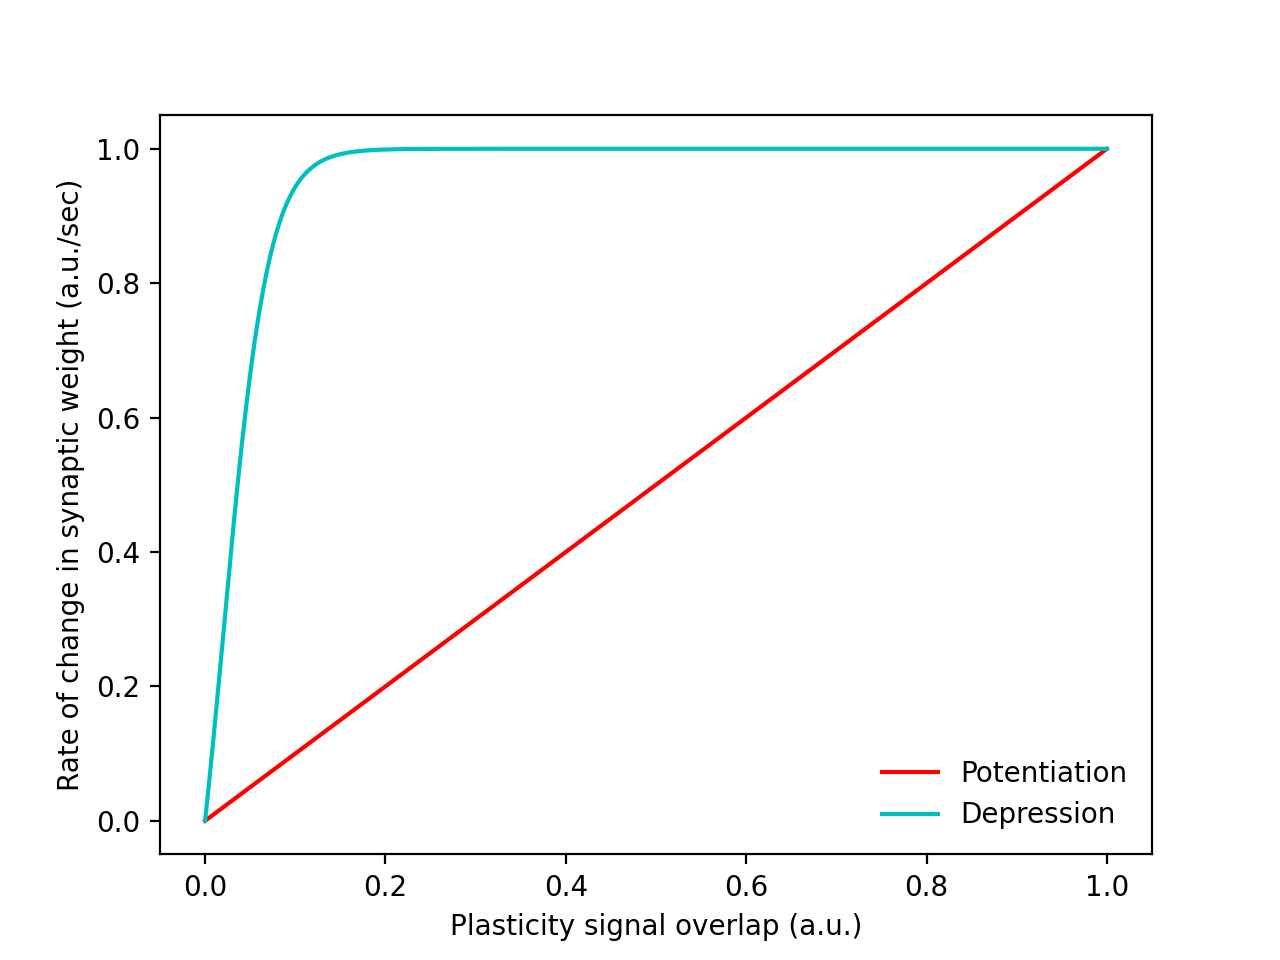

In [186]:
signal_range = np.linspace(0., 1., 1000)
plt.figure()
plt.plot(signal_range, q_pot(signal_range), c='r', label='Potentiation')
plt.plot(signal_range, q_dep(signal_range), c='c', label='Depression')
plt.ylabel('Rate of change in synaptic weight (a.u./sec)')
plt.xlabel('Plasticity signal overlap (a.u.)')
plt.legend(loc='best', frameon=False)
plt.show()

Changes in synaptic weight can be thought of as movement of a finite pool of synaptic resources between two states - an active state and an inactive state.<br>
The synaptic weight is proportional to the occupancy of the active state.<br>
Only active resources can engage the depression process and move to the inactive state.<br>
Only inactive resources can engage the potentiation process and move to the active state.<br>

In [188]:
def get_dW_dt(ET_IS, w, pot_f, dep_f, learning_rate, dep_ratio, max_weight):
    return learning_rate * ((max_weight - w) * pot_f(ET_IS) - dep_ratio * w * dep_f(ET_IS))

learning_rate = 0.5
dep_ratio = 0.8
max_weight = 4.
dW_dt = np.empty((100, 100))
w_range = np.linspace(0., max_weight, 100)
signal_range = np.linspace(0., 1., 100)
for i, signal in enumerate(signal_range):
    for j, w in enumerate(w_range):
        this_dw_dt = get_dW_dt(signal, w, q_pot, q_dep, learning_rate, dep_ratio, max_weight)
        dW_dt[j,i] = this_dw_dt

<IPython.core.display.Javascript object>


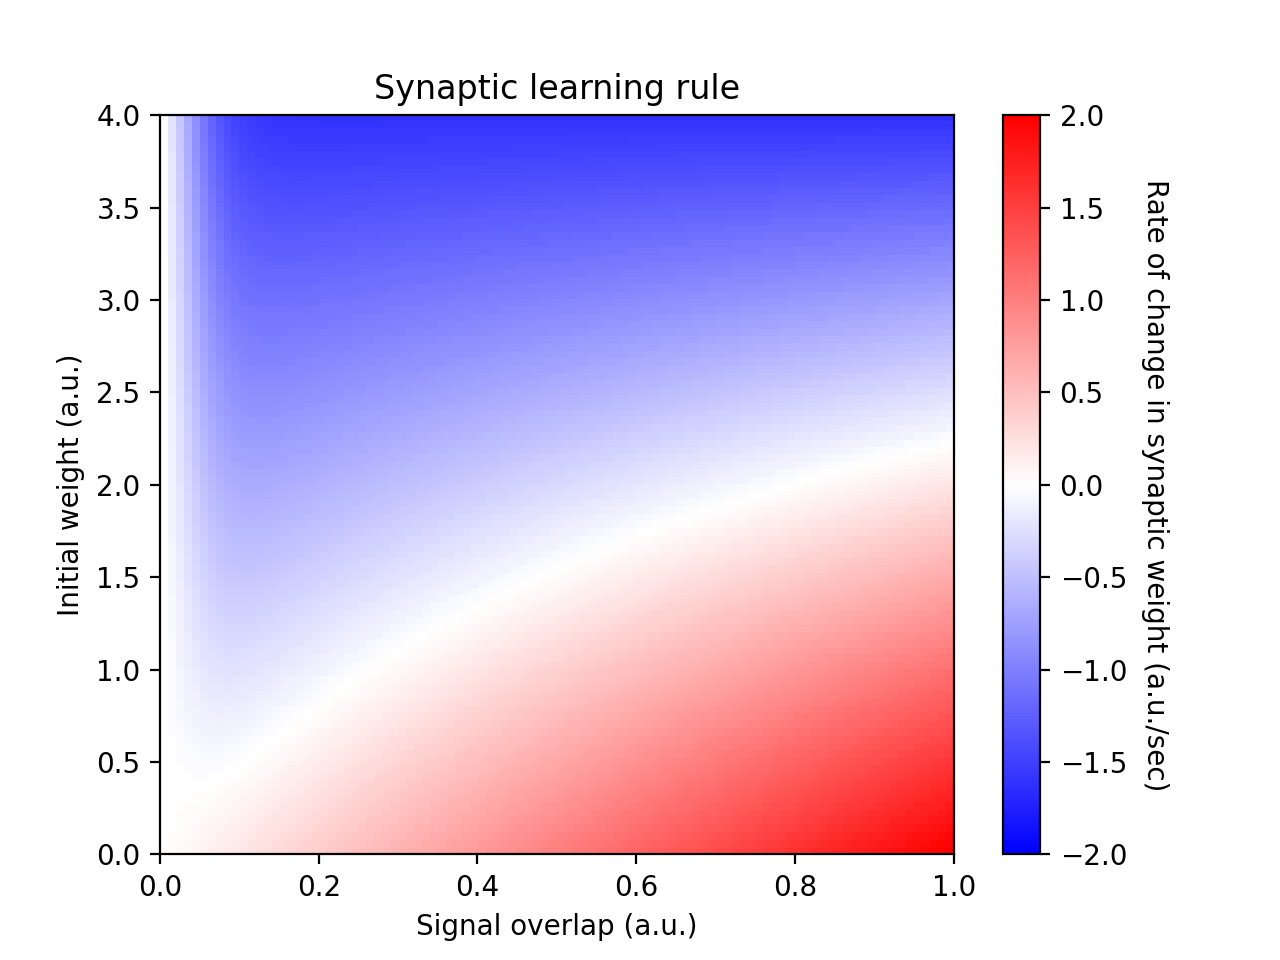

In [189]:
vscale = max(np.abs(np.min(dW_dt)), np.abs(np.max(dW_dt)))

plt.figure()
im = plt.imshow(dW_dt[::-1,:], aspect='auto', cmap='bwr', extent=(0., 1., 0., max_weight), vmin=-vscale, vmax=vscale)
cbar = plt.colorbar(im)
cbar.set_label('Rate of change in synaptic weight (a.u./sec)', rotation=270., labelpad=15)
plt.xlabel('Signal overlap (a.u.)')
plt.ylabel('Initial weight (a.u.)')
plt.title('Synaptic learning rule')
plt.show()

For each pattern of synaptic input, there is a fixed point where the synaptic weight reaches equilibrium, and no further change in synaptic weight can occur.<br><br>
Now, let's look at the evolution of synaptic weights at the 10 inputs to the postsynaptic unit that generated a single dendritic calcium spike at t=5 sec.

In [190]:
w_history = np.empty_like(ET_IS)
w0 = np.ones(pre_activity.shape[0]) * 0.25
w = np.copy(w0)
for i in range(len(t)):
    dw_dt = get_dW_dt(ET_IS[:,i], w, q_pot, q_dep, learning_rate, dep_ratio, max_weight)
    w += dw_dt * dt
    w = np.maximum(0., np.minimum(w, max_weight))
    w_history[:,i] = w

<IPython.core.display.Javascript object>


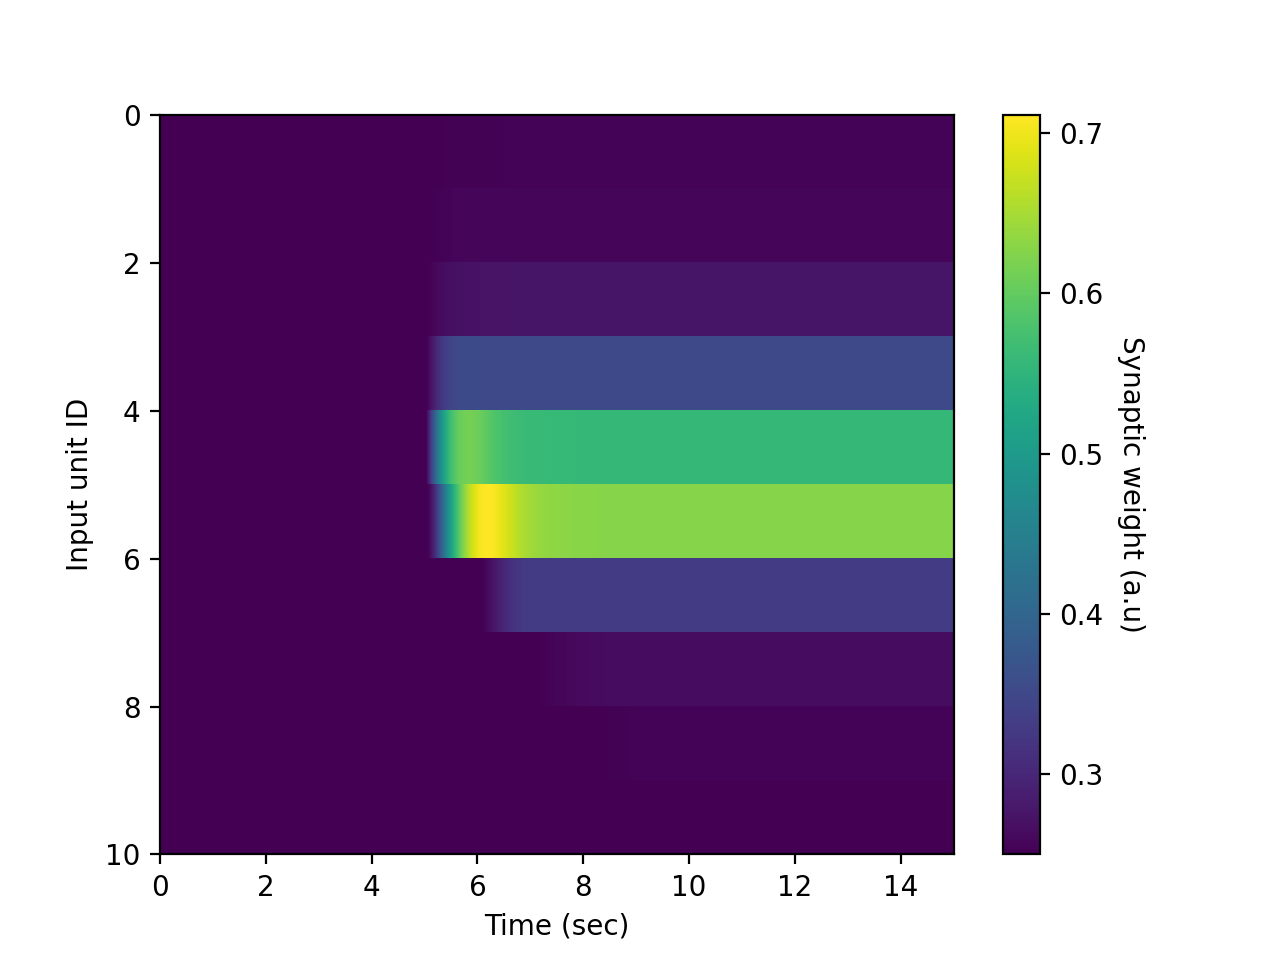

In [191]:
plt.figure()
im = plt.imshow(w_history, aspect='auto', extent=(0., t_lim, input_dim, 0), interpolation='none')
cbar = plt.colorbar(im)
cbar.set_label('Synaptic weight (a.u)', rotation=270., labelpad=15)
plt.xlabel('Time (sec)')
plt.ylabel('Input unit ID')
plt.show()

Now, after this single trial, this postsynaptic unit has elevated synaptic weights at the inputs that were active nearby in time to the dendritic calcium spike event.

<IPython.core.display.Javascript object>


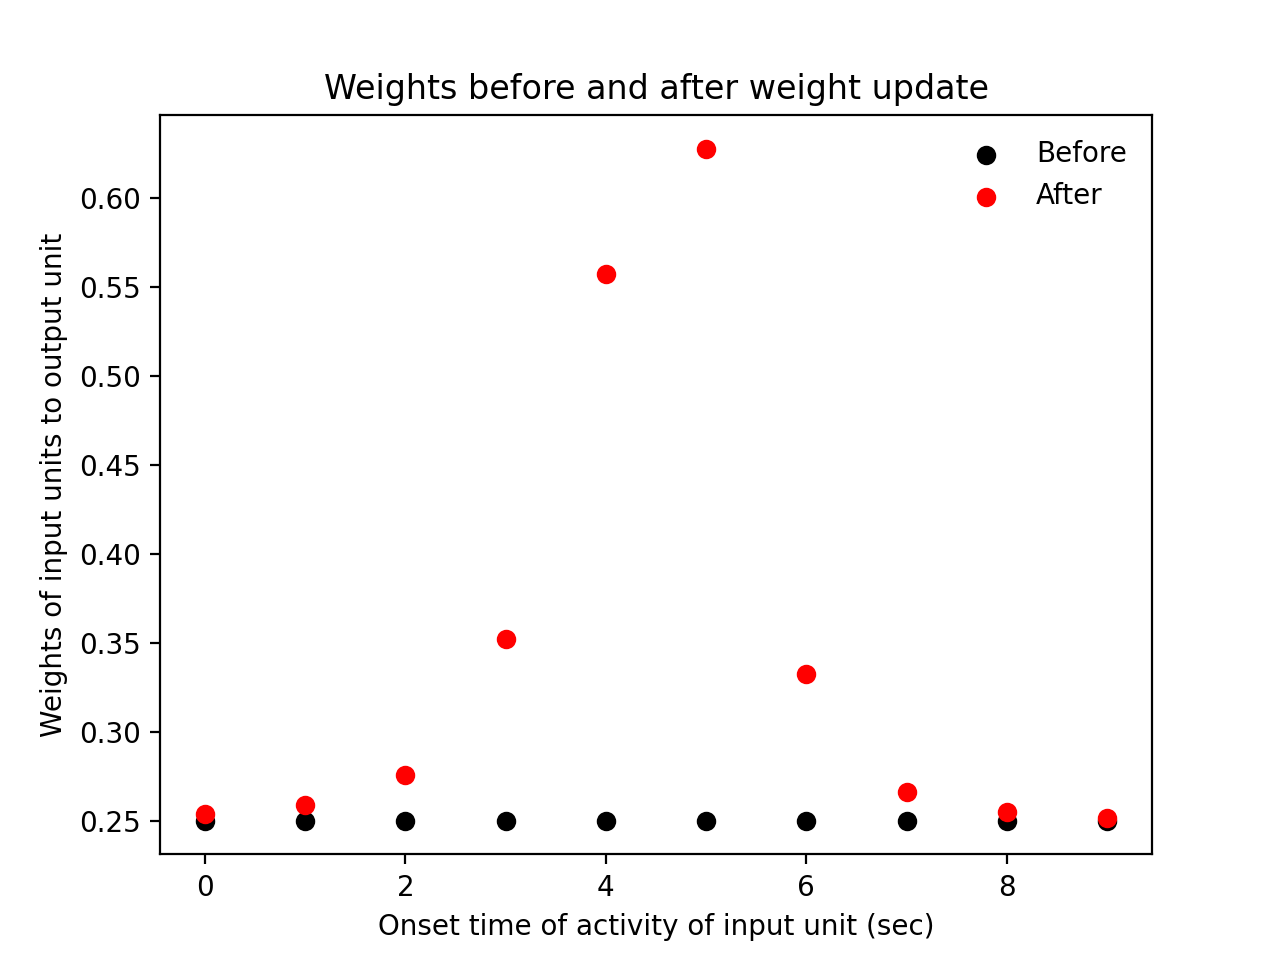

In [192]:
w_final = np.array(w_history[:,-1])
plt.figure()
plt.scatter(input_locs, w0, c='k', label='Before')
plt.scatter(input_locs, w_final, c='r', label='After')
plt.legend(loc='best', frameon=False)
plt.ylabel('Weights of input units to output unit')
plt.xlabel('Onset time of activity of input unit (sec)')
plt.title('Weights before and after weight update')
plt.show()

Now let's present the same pattern of inputs to the postsynaptic cell and measure its voltage response:

In [201]:
weights = np.copy(w_final)

v = []
vi = v0
post_activity = []
last_spike_time = None

for i in range(len(t)):
    if last_spike_time is None or t[i] - last_spike_time > spike_dur + spike_refractory:
        if vi >= v_spike_th:
            vi = 1.
            last_spike_time = t[i]
            post_activity.append(1.)
        else:
            # weighted sum of inputs in this time step
            summed_input = weights.dot(pre_activity[:,i])
            dv_dt = get_exp_decay_dsignal_dt(summed_input, vi, v_decay_tau, v_act_rate)
            vi += dv_dt * dt
            post_activity.append(0.)
    elif t[i] - last_spike_time < spike_dur:
        vi = 1.
        post_activity.append(1.)
    elif t[i] - last_spike_time < spike_dur + spike_refractory:
        vi = 0.
        post_activity.append(0.)
    v.append(vi)

<IPython.core.display.Javascript object>


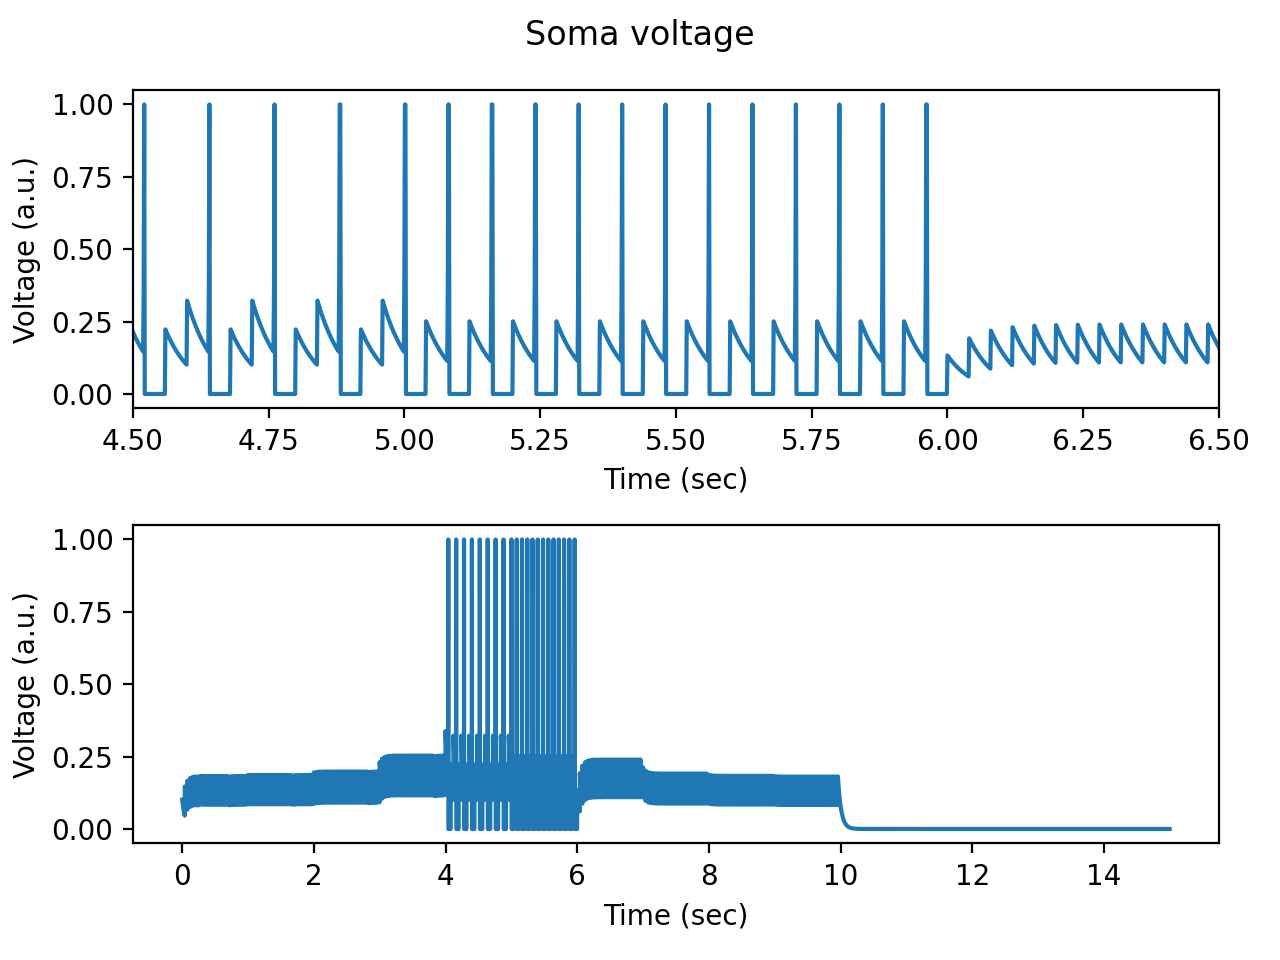

In [202]:
fig, axes = plt.subplots(2)
axes[0].plot(t, v)
axes[1].plot(t, v)
axes[0].set_xlim(4.5, 6.5)
axes[0].set_ylabel('Voltage (a.u.)')
axes[1].set_ylabel('Voltage (a.u.)')
fig.suptitle('Soma voltage')
axes[0].set_xlabel('Time (sec)')
axes[1].set_xlabel('Time (sec)')
fig.tight_layout()
fig.show()

There is one more detail, which is that when dendritic calcium spikes are generated in the dendritic compartment,<br>
they can influence the output of the cell by injecting current into the soma compartment.<br>
Let's modify our soma compartment to include the influence of the dendrite.<br>
It's influence will be controlled by a coupling coefficient.

In [203]:
v = []
vi = v0
post_activity = []
last_spike_time = None
dend_soma_coupling = 0.1

dend_v = []
dend_vi = dend_v0

dend_ca_spike = []
last_ca_spike_time = None

for i in range(len(t)):
    if last_ca_spike_time is None or t[i] - last_ca_spike_time > ca_spike_dur + ca_spike_refractory:
        if dend_vi >= dend_v_ca_spike_th:
            last_ca_spike_time = t[i]
            dend_vi = 1.
            dend_ca_spike.append(1.)
        else:
            d_dend_v_dt = get_exp_decay_dsignal_dt(teaching_input[i], dend_vi, dend_v_decay_tau, dend_v_act_rate)
            dend_vi += d_dend_v_dt * dt    
            dend_ca_spike.append(0.)
    elif t[i] - last_ca_spike_time < ca_spike_dur:
        dend_vi = 1.
        dend_ca_spike.append(1.)
    elif t[i] - last_ca_spike_time < ca_spike_dur + ca_spike_refractory:
        dend_vi = 0.
        dend_ca_spike.append(0.)
    dend_v.append(dend_vi)
    
    if last_spike_time is None or t[i] - last_spike_time > spike_dur + spike_refractory:
        if vi >= v_spike_th:
            vi = 1.
            last_spike_time = t[i]
            post_activity.append(1.)
        else:
            # weighted sum of inputs in this time step
            summed_input = weights.dot(pre_activity[:,i])
            summed_input += dend_ca_spike[-1] * dend_soma_coupling
            dv_dt = get_exp_decay_dsignal_dt(summed_input, vi, v_decay_tau, v_act_rate)
            vi += dv_dt * dt
            post_activity.append(0.)
    elif t[i] - last_spike_time < spike_dur:
        vi = 1.
        post_activity.append(1.)
    elif t[i] - last_spike_time < spike_dur + spike_refractory:
        vi = 0.
        post_activity.append(0.)
    v.append(vi)

<IPython.core.display.Javascript object>


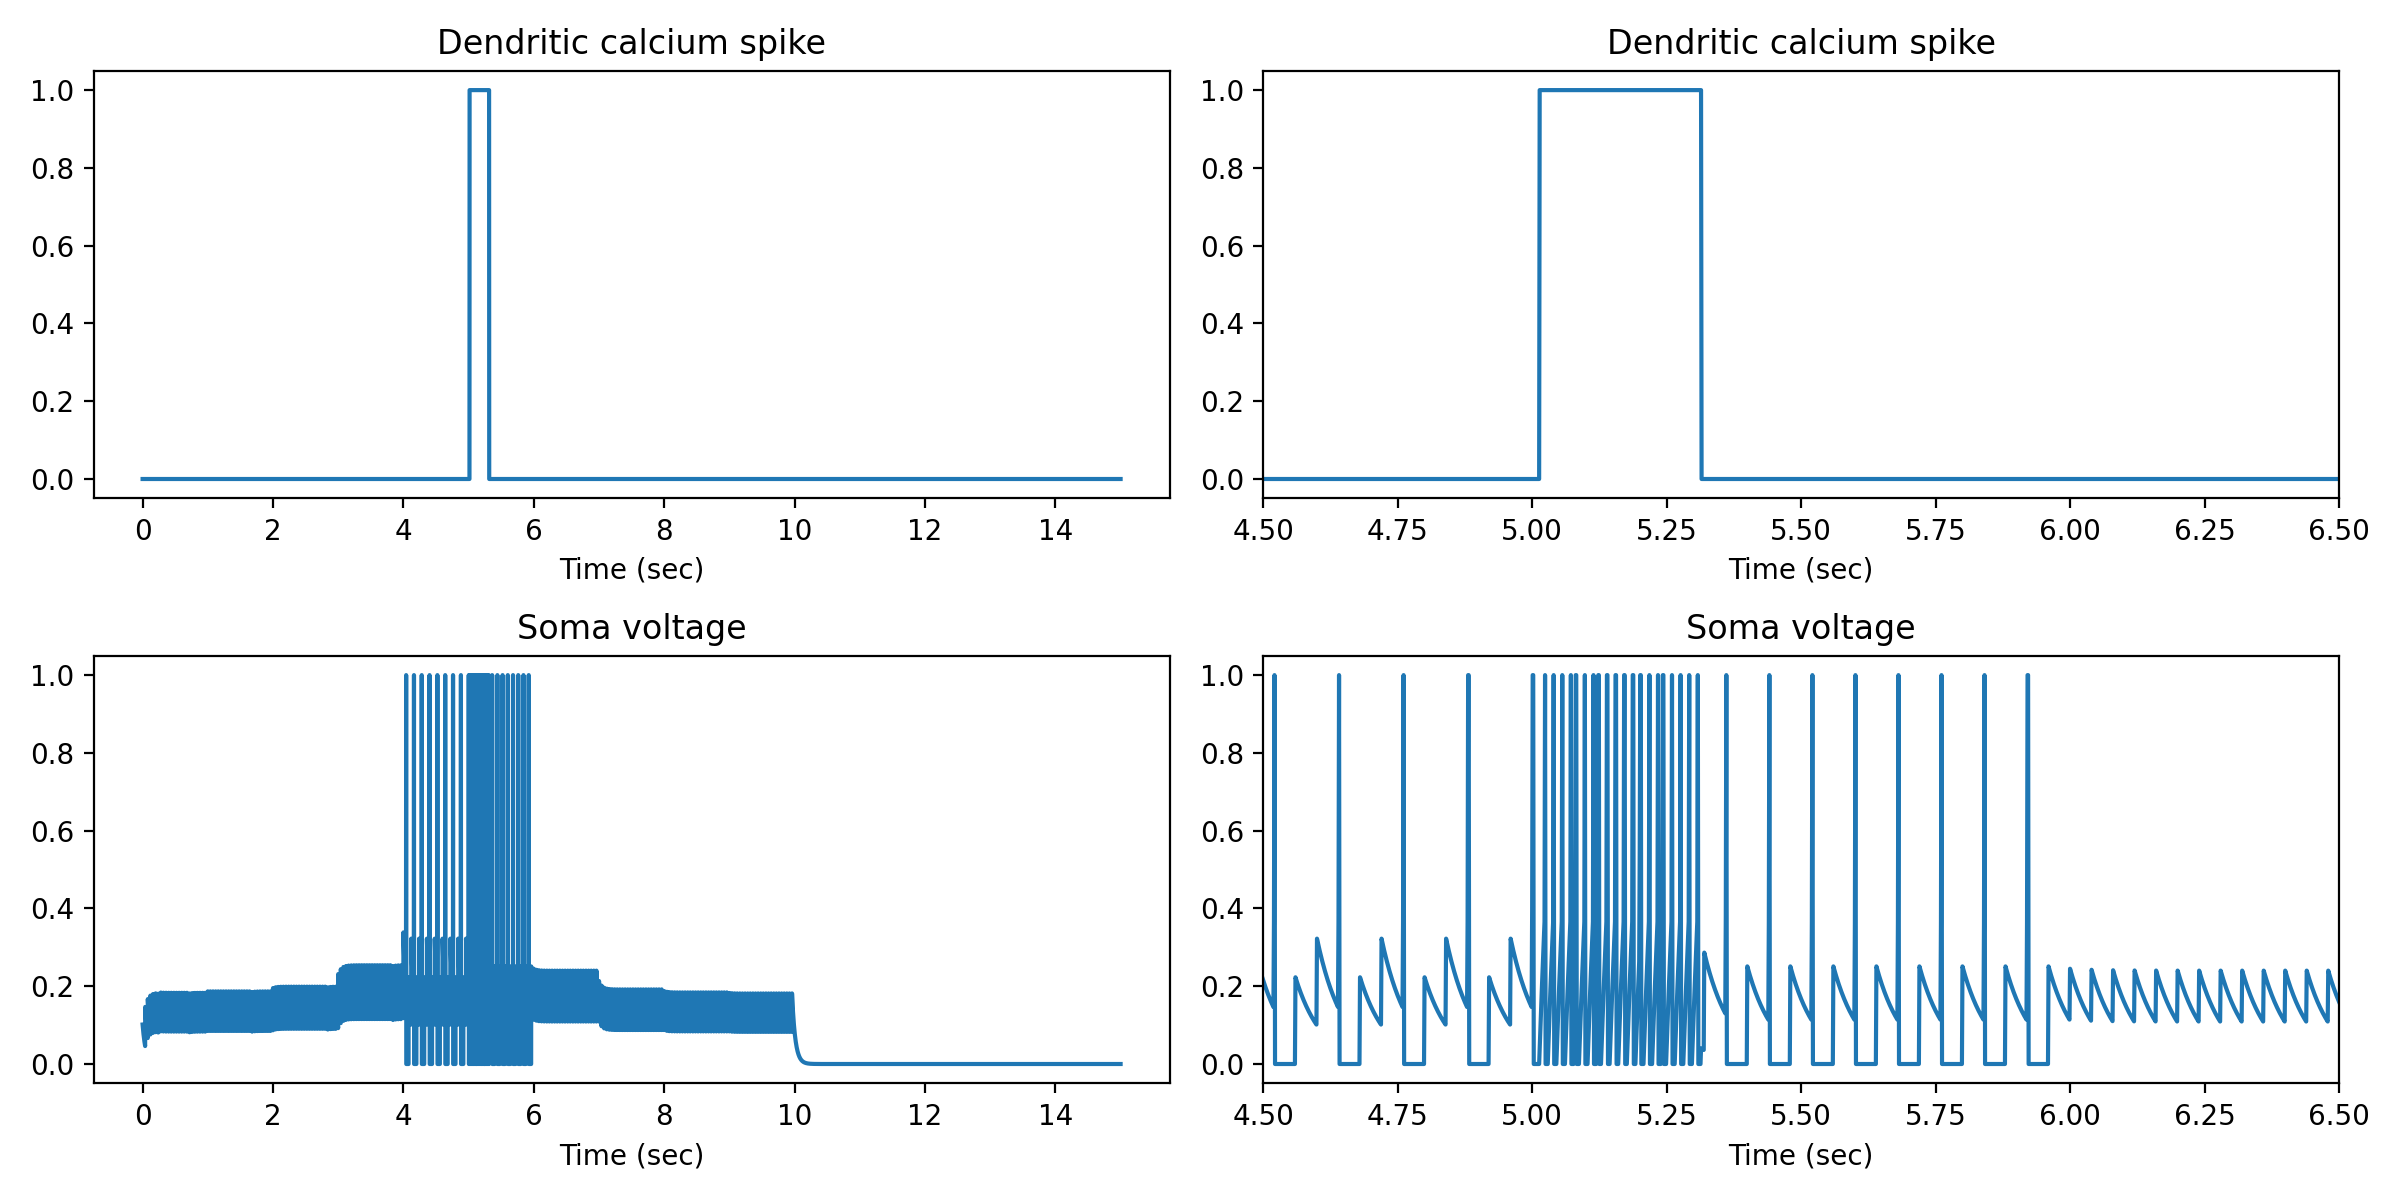

In [208]:
fig, axes = plt.subplots(2, 2, figsize=(12., 6.))
axes[0][0].plot(t, dend_ca_spike)
axes[0][0].set_title('Dendritic calcium spike')
axes[1][0].plot(t, v)
axes[0][1].plot(t, dend_ca_spike)
axes[0][1].set_title('Dendritic calcium spike')
axes[0][1].set_xlim(4.5, 6.5)
axes[1][1].plot(t, v)
axes[1][1].set_xlim(4.5, 6.5)
axes[1][0].set_title('Soma voltage')
axes[1][1].set_title('Soma voltage')
axes[0][0].set_xlabel('Time (sec)')
axes[0][1].set_xlabel('Time (sec)')
axes[1][0].set_xlabel('Time (sec)')
axes[1][1].set_xlabel('Time (sec)')
fig.tight_layout()
fig.show()